In [2]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import math
import os
from dateutil.relativedelta import relativedelta
from sklearn.cluster import KMeans
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_tree
# Logistic Regresison 
import statsmodels
from  statsmodels.discrete.discrete_model import Logit
import sklearn
from sklearn.linear_model import LogisticRegression

In [3]:
product_sale = pd.read_csv(r'C:\Users\Admin\RBAC\Round3_RBAC\ProductSales.csv')
kmean_map = pd.read_csv(r'C:\Users\Admin\RBAC\Round 2\Transformed_Data\Kmean_4.csv', index_col=0)
cust_data = pd.read_csv(r'C:\Users\Admin\RBAC\Round 2\Transformed_Data\Customer_data.csv', index_col=0)

In [4]:
product_map = pd.read_csv(r'C:\Users\Admin\RBAC\Round3_RBAC\ProductMapping.csv')
voucher_map = pd.read_csv(r'C:\Users\Admin\RBAC\Round3_RBAC\VoucherMapping.csv')

In [5]:
product_sale

,BillID,TransactionDate,TransactionTime,Channel,OrderFrom,FatherCode,FoodCode,ItemTotalQuantity,NetAmount,LEVEL_1,LEVEL_2,LEVEL_3,CustomerID
0,0,1/1/2021,10:09,Delivery,CallCenter,3304.0,3304,1,0,PROMOTION,BOGO,BOGO REGULAR 2020,6402
1,0,1/1/2021,10:09,Delivery,CallCenter,3304.0,3316,1,0,PROMOTION,BOGO,BOGO REGULAR 2020,6402
2,0,1/1/2021,10:09,Delivery,CallCenter,3304.0,2018,1,38182,PROMOTION,BOGO,BOGO REGULAR 2020,6402
3,0,1/1/2021,10:09,Delivery,CallCenter,3304.0,320,1,36364,PROMOTION,BOGO,BOGO REGULAR 2020,6402
4,0,1/1/2021,10:09,Delivery,CallCenter,3304.0,2468,1,190000,PROMOTION,BOGO,BOGO REGULAR 2020,6402
...,...,...,...,...,...,...,...,...,...,...,...,...,...
762068,168433,11/25/2022,16:54,Delivery,STORE,3438.0,3438,1,20370,DELIVERY FEE,DELIVERY FEE,DELIVERY FEE,10882
762069,168434,11/25/2022,17:50,Take Away,STORE,2049.0,2049,1,0,PROMOTION,B1G3,B1G3,14672
762070,168434,11/25/2022,17:50,Take Away,STORE,2049.0,2058,1,323148,PROMOTION,B1G3,B1G3,14672
762071,168434,11/25/2022,17:50,Take Away,STORE,2049.0,2069,1,0,PROMOTION,B1G3,B1G3,14672


# 1 | RFM

In [6]:
# getting the latest day of purchase for each user
product_sale['TransactionDate'] = pd.to_datetime(product_sale['TransactionDate'])
recency_table = product_sale.groupby('CustomerID').agg({'TransactionDate': 'max'}).reset_index()
# calculate the current day 
current_day = pd.to_datetime(max(product_sale['TransactionDate']))
# calculate the days between
recency_table['days_between'] = (current_day - recency_table['TransactionDate']).apply(lambda x: int(str(x).split()[0]))
# def function that scores the data
def scoring(x):
    # calculate quantiles
    quan_val_list = []
    for quan in [0.2,0.4,0.6,0.8]:
        quan_val_list.append(np.quantile(x,quan))
    # label the data base on the quantile value
    def labeling(x):
        if x < quan_val_list[0]: return 5
        elif x < quan_val_list[1]: return 4
        elif x < quan_val_list[2]: return 3
        elif x < quan_val_list[3]: return 2
        else: return 1

    return x.apply(labeling)

recency_table['recency_score'] = scoring(recency_table['days_between'])
recency_table

,CustomerID,TransactionDate,days_between,recency_score
0,0,2022-08-14,103,4
1,1,2022-08-14,103,4
2,2,2021-12-20,340,2
3,3,2021-01-23,671,1
4,4,2021-12-03,357,2
...,...,...,...,...
30989,30989,2022-06-20,158,4
30990,30990,2021-12-25,335,2
30991,30991,2022-02-09,289,2
30992,30992,2022-02-20,278,2


In [7]:
# frequency
df = product_sale.copy().drop_duplicates(subset=['CustomerID','BillID'])
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df.sort_values(by=['CustomerID', 'TransactionDate'], inplace=True)
df['DaysBetweenPurchases'] = df.groupby('CustomerID')['TransactionDate'].diff().dt.days
frequency_table = df.groupby('CustomerID', as_index=False).agg(MeanDaysBetweenPurchase=('DaysBetweenPurchases','mean'),MaxDaysBetweenPurchase=('DaysBetweenPurchases','max'))

# def function that scores the data
def scoring(x):
    # calculate quantiles
    quan_val_list = []
    for quan in [0.2,0.4,0.6,0.8]:
        quan_val_list.append(np.quantile(x,quan))
    # label the data base on the quantile value
    def labeling(x):
        if x < quan_val_list[0]: return 5
        elif x < quan_val_list[1]: return 4
        elif x < quan_val_list[2]: return 3
        elif x < quan_val_list[3]: return 2
        else: return 1

    return x.apply(labeling)

frequency_table['frequency_score'] = scoring(frequency_table['MeanDaysBetweenPurchase'])
frequency_table

,CustomerID,MeanDaysBetweenPurchase,MaxDaysBetweenPurchase,frequency_score
0,0,249.000000,265.0,1
1,1,219.000000,375.0,1
2,2,101.500000,192.0,1
3,3,NaN,NaN,1
4,4,124.500000,172.0,1
...,...,...,...,...
30989,30989,71.142857,135.0,1
30990,30990,101.000000,199.0,1
30991,30991,NaN,NaN,1
30992,30992,327.000000,327.0,1


In [8]:
full_cust = list(product_sale['CustomerID'].unique()) 
temp_cust = list(frequency_table['CustomerID'].unique())
missing_cust = []
for cust in full_cust:
    if cust not in temp_cust:
        missing_cust.append(cust)
concated = pd.concat([frequency_table, pd.DataFrame(missing_cust, columns=['CustomerID'])])
concated['frequency_score'][concated['CustomerID'].isin(missing_cust)] = 1
frequency_table = concated
frequency_table

C:\Users\Admin\AppData\Local\Temp\ipykernel_2500\2183510044.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concated['frequency_score'][concated['CustomerID'].isin(missing_cust)] = 1


,CustomerID,MeanDaysBetweenPurchase,MaxDaysBetweenPurchase,frequency_score
0,0,249.000000,265.0,1.0
1,1,219.000000,375.0,1.0
2,2,101.500000,192.0,1.0
3,3,NaN,NaN,1.0
4,4,124.500000,172.0,1.0
...,...,...,...,...
30989,30989,71.142857,135.0,1.0
30990,30990,101.000000,199.0,1.0
30991,30991,NaN,NaN,1.0
30992,30992,327.000000,327.0,1.0


In [9]:
monetary_table = product_sale.groupby('CustomerID',as_index=False).agg(total_value=('NetAmount','sum'))
temp = product_sale.groupby(['CustomerID','BillID'],as_index=False).agg(total_value=('NetAmount','sum'))
monetary_table['avg_value_per_order'] = temp.groupby('CustomerID',as_index=False).agg(avg_value_per_order = ('total_value','mean'))['avg_value_per_order']

# def function that scores the data
def scoring(x):
    # calculate quantiles
    quan_val_list = []
    for quan in [0.2,0.4,0.6,0.8]:
        quan_val_list.append(np.quantile(x,quan))
    # label the data base on the quantile value
    def labeling(x):
        if x < quan_val_list[0]: return 1
        elif x < quan_val_list[1]: return 2
        elif x < quan_val_list[2]: return 3
        elif x < quan_val_list[3]: return 4
        else: return 5

    return x.apply(labeling)

monetary_table['monetary_score'] = scoring(monetary_table['total_value'])
monetary_table

,CustomerID,total_value,avg_value_per_order,monetary_score
0,0,983639,327879.666667,2
1,1,832694,277564.666667,2
2,2,768718,256239.333333,2
3,3,320909,320909.000000,1
4,4,728292,242764.000000,2
...,...,...,...,...
30989,30989,2401800,300225.000000,4
30990,30990,796720,265573.333333,2
30991,30991,277778,277778.000000,1
30992,30992,367795,183897.500000,1


In [10]:
final_table = recency_table.merge(monetary_table, on = 'CustomerID').merge(frequency_table, on='CustomerID')

def scoring(x):
    # calculate quantiles
    quan_val_list = []
    for quan in [0.2,0.4,0.6,0.8]:
        quan_val_list.append(np.quantile(x,quan))
    # label the data base on the quantile value
    def labeling(x):
        if x < quan_val_list[0]: return 1
        elif x < quan_val_list[1]: return 2
        elif x < quan_val_list[2]: return 3
        elif x < quan_val_list[3]: return 4
        else: return 5

    return x.apply(labeling)


final_table['frequency_monetary_score'] = scoring(final_table['frequency_score'] + final_table['monetary_score'])
final_table

segment_dict = {# hibernating
(1,1):"hibernating",
(1,2):"hibernating",
(2,1):"hibernating",
(2,2):"hibernating",
# about to sleep
(3,1):"about to sleep",
(3,2):"about to sleep",
# promising
(4,1):"promising",
# new customer
(5,1):"new customer",
# potential customers
(4,2):"potential",
(4,3):"potential",
(5,2):"potential",
(5,3):"potential",
# need attion
(3,3):"need attion",
# at risk
(1,3):"at risk",
(1,4):"at risk",
(2,3):"at risk",
(2,4):"at risk",
# do not lose
(1,5):"do not lose",
(2,5):"do not lose",
# loyal customer
(3,4):"loyal",
(3,5):"loyal",
(4,4):"loyal",
(4,5):"loyal",
# champions
(5,4):"champions",
(5,5):"champions"}

final_table['segment'] = final_table.apply(lambda x:
                  segment_dict[(x['recency_score'],x['frequency_monetary_score'])]
                  , axis = 1
                  )
final_table

,CustomerID,TransactionDate,days_between,recency_score,total_value,avg_value_per_order,monetary_score,MeanDaysBetweenPurchase,MaxDaysBetweenPurchase,frequency_score,frequency_monetary_score,segment
0,0,2022-08-14,103,4,983639,327879.666667,2,249.000000,265.0,1.0,2,potential
1,1,2022-08-14,103,4,832694,277564.666667,2,219.000000,375.0,1.0,2,potential
2,2,2021-12-20,340,2,768718,256239.333333,2,101.500000,192.0,1.0,2,hibernating
3,3,2021-01-23,671,1,320909,320909.000000,1,NaN,NaN,1.0,1,hibernating
4,4,2021-12-03,357,2,728292,242764.000000,2,124.500000,172.0,1.0,2,hibernating
...,...,...,...,...,...,...,...,...,...,...,...,...
30989,30989,2022-06-20,158,4,2401800,300225.000000,4,71.142857,135.0,1.0,4,loyal
30990,30990,2021-12-25,335,2,796720,265573.333333,2,101.000000,199.0,1.0,2,hibernating
30991,30991,2022-02-09,289,2,277778,277778.000000,1,NaN,NaN,1.0,1,hibernating
30992,30992,2022-02-20,278,2,367795,183897.500000,1,327.000000,327.0,1.0,1,hibernating


In [11]:
final_table_extracted = final_table[['CustomerID','days_between','total_value','avg_value_per_order','MeanDaysBetweenPurchase','MaxDaysBetweenPurchase']]
final_table_extracted = final_table_extracted.rename(columns={'days_between':'days_between_first_last_order','MeanDaysBetweenPurchase':'Mean_Days_Between_Purchase','MaxDaysBetweenPurchase':'Max_Days_Between_Purchase'})
# final_table_extracted.to_csv(r'RFM_Value_Extracted.csv')

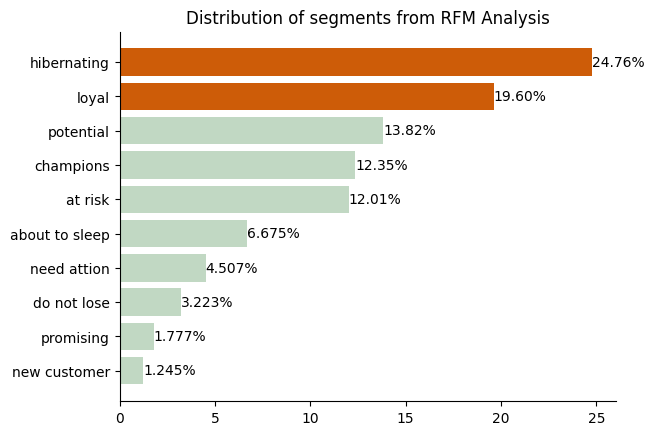

In [12]:
final_data = final_table['segment'].value_counts()
final_data = final_data.apply(lambda x: x*100/np.sum(final_data.values)).sort_values(ascending=True)
fig, ax = plt.subplots()
sns.despine()

color_map = ["#C1D8C3"] * len(final_data)
color_map[-2] = color_map[-1] = '#CD5C08'

ax.barh(
    y =  final_data.index, 
    width =  final_data.values,
    color = color_map
)

ax.set_title('Distribution of segments from RFM Analysis')

for ind, val in final_data.items():
    ax.annotate(
        str(val)[:5] + "%",
        xy = (val,ind), va='center'
    )

# 2 | Product-related

## 2.1 | Combo

In [13]:
combo_table = product_sale[product_sale['FatherCode'] != product_sale['FoodCode']].drop_duplicates(subset=['BillID','FatherCode']).groupby(['BillID','CustomerID'],as_index=False).agg(Combo_count=('FatherCode','count'))

In [14]:
product_per_order_table = product_sale.drop_duplicates(subset=['BillID','FatherCode']).groupby(['BillID','CustomerID'],as_index=False).agg(product_count =('FatherCode','count'))
product_per_order_table.sort_values('product_count')

,BillID,CustomerID,product_count
168434,168434,14672,1
57234,57234,21182,1
57233,57233,12770,1
57232,57232,11303,1
57231,57231,2595,1
...,...,...,...
32615,32615,4197,15
72944,72944,19686,16
30554,30554,13634,16
129400,129400,27557,17


In [15]:
combo_single_table= combo_table.merge(product_per_order_table, on = ['BillID','CustomerID'])
combo_single_table['single_item_count'] = combo_single_table['product_count'] - combo_single_table['Combo_count']
combo_single_table_agg = combo_single_table.groupby('CustomerID',as_index=False).agg(total_combo_count = ('Combo_count','sum'), total_product_count = ('product_count','sum'), total_single_item_count = ('single_item_count','sum'))

In [16]:
combo_single_table_agg['combo_usage_rate'] = combo_single_table_agg['total_combo_count'] / combo_single_table_agg['total_product_count']
combo_single_table_agg['single_item_usage_rate'] = combo_single_table_agg['total_single_item_count'] / combo_single_table_agg['total_product_count']

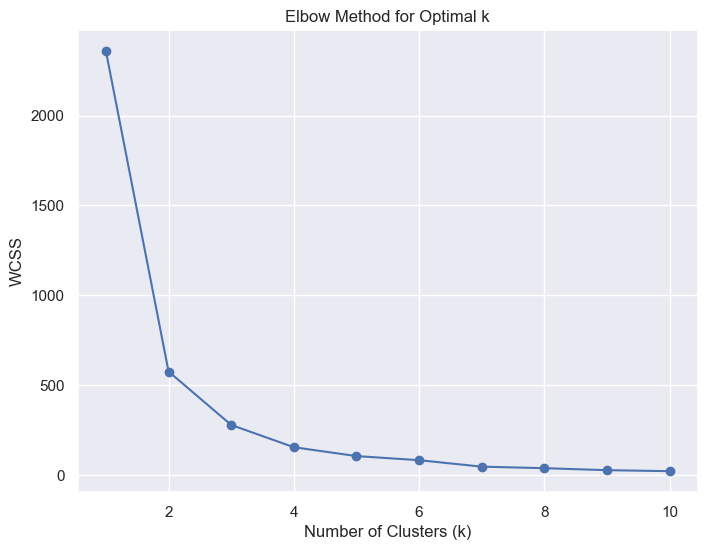

,k_values,wcss,Percentage_Reduction
0,1,2359.363443,0.000000
1,2,575.078328,75.625700
2,3,277.557113,51.735772
3,4,153.464885,44.708718
4,5,104.095653,32.169726
5,6,81.191476,22.003010
6,7,45.235270,44.285691
7,8,36.697802,18.873477
8,9,25.592332,30.261947
9,10,20.044222,21.678800


In [17]:
wcss = []  # List to store the within-cluster sum of squares
kmean_col = ['combo_usage_rate','single_item_usage_rate']
k_values = range(1, 11)  # You can adjust the range as needed

for k in k_values:
    wcss_for_k = []  # List to store WCSS for a specific k value
    for _ in k_values:  # Number of random initializations (adjust as needed)
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=3)  # You can adjust other parameters
        kmeans.fit(combo_single_table_agg[kmean_col])
        wcss_for_k.append(kmeans.inertia_)  # Inertia is WCSS
    wcss.append(np.mean(wcss_for_k))  # Take the mean of WCSS for this k value

sns.set_theme() 
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Create df
elbow_df = pd.DataFrame({'k_values':k_values,'wcss':wcss})
percentage_reduction = [0,]
for i in range(1, len(elbow_df)):
    wcss_previous = elbow_df['wcss'][i - 1]
    wcss_current = elbow_df['wcss'][i]
    reduction = ((wcss_previous - wcss_current) / wcss_previous) * 100
    percentage_reduction.append(reduction)

elbow_df['Percentage_Reduction'] = percentage_reduction
display(elbow_df)

In [18]:
k_values_to_choose = 2
kmean_col = ['combo_usage_rate','single_item_usage_rate']

kmeans = KMeans(n_clusters= k_values_to_choose, init='k-means++', n_init='auto', random_state=2)  # You can adjust other parameters
kmeans.fit(combo_single_table_agg[kmean_col])
combo_single_table_agg['Cluster'] = kmeans.labels_

def rename(x):
    if x == 0: return 'Single_item_prefered'
    elif x == 1: return 'Combo_prefered'

combo_single_table_agg['Cluster'] = combo_single_table_agg['Cluster'].apply(rename)


In [19]:
full_cust = list(product_sale['CustomerID'].unique()) 
temp_cust = list(combo_single_table_agg['CustomerID'].unique())
missing_cust = []
for cust in full_cust:
    if cust not in temp_cust:
        missing_cust.append(cust)

In [20]:
concated = pd.concat([combo_single_table_agg, pd.DataFrame(missing_cust, columns=['CustomerID'])])
concated['Cluster'][concated['CustomerID'].isin(missing_cust)] = 'Single_item_prefered'
combo_single_table_agg = concated

C:\Users\Admin\AppData\Local\Temp\ipykernel_2500\706525846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concated['Cluster'][concated['CustomerID'].isin(missing_cust)] = 'Single_item_prefered'


In [21]:
# combo_single_table_agg.to_csv('R3_Kmean1.csv')

## 2.2 | Size

In [22]:
merged = product_sale.merge(product_map, on='FoodCode',how='left')[['BillID','CustomerID','FatherCode','FoodCode','SIZE']]
size_table = merged.groupby(['CustomerID','SIZE'],as_index=False).agg(purchase_count = ('BillID','count'))
# total item
total_item_tab = product_sale.groupby('CustomerID',as_index=False).agg(total_item_purchase = ('BillID','count'))[['CustomerID','total_item_purchase']]
# merging
temp = size_table.merge(total_item_tab, on = 'CustomerID', how='left')
temp['usage_rate'] = temp['purchase_count']/ temp['total_item_purchase']


In [23]:
temp['max_usage'] = temp.groupby('CustomerID')['usage_rate'].transform('max')

In [24]:
size_pref_table = temp[temp['usage_rate'] == temp['max_usage']].drop_duplicates(subset=['CustomerID'])[['CustomerID','SIZE']].rename(columns={'SIZE':'Favourite_piz_size'})

In [25]:
size_pref_table

,CustomerID,Favourite_piz_size
0,0,LARGE
4,1,REGULAR
5,2,REGULAR
6,3,LARGE
7,4,LARGE
...,...,...
62308,30989,REGULAR
62309,30990,REGULAR
62310,30991,PERSONAL
62312,30992,REGULAR


## 3 | Voucher

In [26]:
voucher_map

,BillID,VoucherCampaignName,VoucherValue,Total_Bill_Amount_Apply
0,154195,Campaign 59,111000.00,290000.0
1,21592,Campaign 12,98033.33,NaN
2,21592,Campaign 133,98033.33,NaN
3,21592,Campaign 41,98033.33,NaN
4,161991,Campaign 92,100000.00,320000.0
...,...,...,...,...
4277,134908,Campaign 71,100000.00,359000.0
4278,124463,Campaign 79,100000.00,250000.0
4279,114726,Campaign 129,100000.00,250000.0
4280,108692,Campaign 144,100000.00,250000.0


In [27]:
temp = product_sale.groupby(['CustomerID','LEVEL_1'],as_index=False).agg(purchase_count = ('BillID','count'))
temp['max_cnt'] = temp.groupby('CustomerID')['purchase_count'].transform('max')
voucher_pref_table =  temp[temp['purchase_count'] == temp['max_cnt']].drop_duplicates(subset='CustomerID')
voucher_pref_table = voucher_pref_table.rename(columns={'LEVEL_1':'favourite_voucher_lv1'})
voucher_pref_table

,CustomerID,favourite_voucher_lv1,purchase_count,max_cnt
1,0,PROMOTION,12,12
4,1,PROMOTION,8,8
6,2,PROMOTION,11,11
8,3,PROMOTION,4,4
10,4,PROMOTION,11,11
...,...,...,...,...
75251,30989,PROMOTION,32,32
75254,30990,PROMOTION,11,11
75257,30991,PROMOTION,4,4
75260,30992,PROMOTION,4,4


In [28]:
temp = product_sale.groupby(['CustomerID','LEVEL_1','LEVEL_2'],as_index=False).agg(purchase_count = ('BillID','count'))
temp['max_cnt'] = temp.groupby('CustomerID')['purchase_count'].transform('max')
voucher_pref_table_2 =  temp[temp['purchase_count'] == temp['max_cnt']].drop_duplicates(subset='CustomerID')
voucher_pref_table_2['favourite_voucher_lv2'] = voucher_pref_table_2.apply(lambda x: x['LEVEL_1'] + "_" + x['LEVEL_2'], axis=1)
voucher_pref_table_2 = voucher_pref_table_2[['CustomerID','favourite_voucher_lv2']]
voucher_pref_table_2

,CustomerID,favourite_voucher_lv2
2,0,PROMOTION_BOGO
5,1,PROMOTION_B1G3
8,2,PROMOTION_BOGO
10,3,PROMOTION_BOGO
12,4,PROMOTION_B1G3
...,...,...
111304,30989,PROMOTION_BOGO
111307,30990,PROMOTION_BOGO
111310,30991,PROMOTION_B1G3
111313,30992,PROMOTION_BOGO


## 4 | Channel

In [29]:
temp = product_sale.drop_duplicates(subset=['BillID']).groupby(['CustomerID','Channel','OrderFrom'],as_index=False).agg(purchase_count = ('BillID','count'))
temp['max_cnt'] = temp.groupby('CustomerID')['purchase_count'].transform('max')
channel_pref_table =  temp[temp['purchase_count'] == temp['max_cnt']].drop_duplicates(subset='CustomerID')
channel_pref_table['favourite_channel'] = channel_pref_table.apply(lambda x: x['Channel'] + "_" + x['OrderFrom'], axis=1)
channel_pref_table = channel_pref_table[['CustomerID','favourite_channel']]
channel_pref_table

,CustomerID,favourite_channel
1,0,Delivery_STORE
2,1,Delivery_CallCenter
4,2,Delivery_CallCenter
6,3,Delivery_CallCenter
7,4,Delivery_WEBSITE
...,...,...
57134,30989,Delivery_CallCenter
57136,30990,Delivery_CallCenter
57138,30991,Delivery_CallCenter
57139,30992,Delivery_STORE


## 5 | Merging

In [30]:
final_table_2= final_table.copy()
combo_single_table_agg_2 = combo_single_table_agg.copy()
size_pref_table_2 = size_pref_table.copy()
voucher_pref_table_2_ = voucher_pref_table.copy()
voucher_pref_table_2_2 = voucher_pref_table_2.copy()
channel_pref_table_2 = channel_pref_table.copy()

In [31]:
final_table_2 = final_table_2[['CustomerID','segment']]
combo_single_table_agg_2 = combo_single_table_agg_2[['CustomerID','Cluster']]
voucher_pref_table_2_ = voucher_pref_table_2_[['CustomerID','favourite_voucher_lv1']]

In [32]:
merge_all_tab = combo_single_table_agg_2.merge(final_table_2, 
                               on = 'CustomerID', how = 'left').merge(size_pref_table_2,
                                                                      on = 'CustomerID', how = 'left').merge(voucher_pref_table_2_,
                                                                                                             on = 'CustomerID', how = 'left').merge(voucher_pref_table_2_2,
                                                                                                                                                     on = 'CustomerID', how = 'left').merge(channel_pref_table_2,
                                                                                                                                                                                            on = 'CustomerID', how = 'left')

In [33]:
# merge_all_tab.to_excel(r'r3_segmentation1.xlsx')